# Модуль 28. Мониторинги и управление качеством моделей

## Проект

**ПОСТАНОВКА ЗАДАЧИ**

В этом проекте вам необходимо реализовать мониторинг модели с помощью *Prometheus* и *Grafana*. Вы можете сами выбрать решаемую задачу и датасет.

**1. Введение**

Т.к. по условиям постановки задачи нам было позволено самостоятельно выбирать решаемую задачу и датасет для нее, то я решил взять  из  юнита 10 "Дообучение моделей. Практика" модуля 28.

**Исходные данные:** Датасет *dataset_ml_28.csv*

In [37]:
# Импорт требуемых модулей и библиотек
import warnings
warnings.filterwarnings("ignore")

from prometheus_client import start_http_server, Gauge
import xgboost as xgb
import re
import numpy as np
import pandas as pd

import lightgbm as lgb
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score

import joblib

## Запустим локальный веб-сервер (порт 9182)

In [38]:
if __name__ == '__main__':
    start_http_server(9182)

##  Загрузка, анализ и предобработка данных датасета

In [39]:
dataset = pd.read_csv('dataset_ml_28.csv')
dataset.head()

,ID,Age,Agency,Agency Type,Commision (in value),Destination,Distribution Channel,Duration,Gender,Net Sales,Product Name,Claim
0,45341,28,C2B,Airlines,28.13,SINGAPORE,Online,34,F,112.5,Silver Plan,1
1,12958,37,JZI,Airlines,12.95,PHILIPPINES,Online,53,F,37.0,Basic Plan,0
2,18233,27,EPX,Travel Agency,0.00,UNITED STATES,Online,28,NaN,13.0,Cancellation Plan,0
3,31742,36,EPX,Travel Agency,0.00,SAUDI ARABIA,Online,1,NaN,34.0,Cancellation Plan,0
4,14381,26,CWT,Travel Agency,23.76,THAILAND,Online,33,NaN,39.6,Rental Vehicle Excess Insurance,0


Рассматриваемый датасет представляет собой данные о страхуемых в страховой компании и предназначен для предсказания, применения санкций к страхованию клиента или нет. Рассмотрим структуру и описание данных более детально.

In [40]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62288 entries, 0 to 62287
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   ID                    62288 non-null  int64  
 1   Age                   62288 non-null  int64  
 2   Agency                62288 non-null  object 
 3   Agency Type           62288 non-null  object 
 4   Commision (in value)  62288 non-null  float64
 5   Destination           62288 non-null  object 
 6   Distribution Channel  62288 non-null  object 
 7   Duration              62288 non-null  int64  
 8   Gender                22713 non-null  object 
 9   Net Sales             62288 non-null  float64
 10  Product Name          62288 non-null  object 
 11  Claim                 62288 non-null  int64  
dtypes: float64(2), int64(4), object(6)
memory usage: 5.7+ MB


In [41]:
dataset.describe()

,ID,Age,Commision (in value),Duration,Net Sales,Claim
count,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000,62288.000000
mean,32844.953458,39.666324,12.829703,60.958804,50.717064,0.200006
std,18065.417216,14.014652,23.498745,114.325330,63.166715,0.400008
min,0.000000,0.000000,0.000000,-2.000000,-389.000000,0.000000
25%,17579.000000,33.000000,0.000000,10.000000,20.000000,0.000000
50%,33446.500000,36.000000,1.880000,25.000000,29.700000,0.000000
75%,48532.250000,43.000000,14.440000,59.000000,58.000000,0.000000
max,63323.000000,118.000000,262.760000,4881.000000,682.000000,1.000000


 ### В колонке Duration минимальное значние "-2", так как продолжительность поездки не может быть меньше 0. Такие данные надо выбросить. Но и максимаьлная продолжительность в 4881 дней, кажется очень большой. Давайте установим максимальное значение "Duration" в 1000 дней.

### Также добавим колонку категориальный признак: сгруппируем клиентов по возрасту ("ребенок", "взрослый", "пожилового возраста"). 

### В колонке пола есть очень много пропусков, который практически никак не заполнить. Поэтому удалим ее.

In [42]:
# Создадим функцию конвертации возраста страхуемого в категориальный признак
def age_convert(age):
    result = ''
    if(age <= 21):
        result = 'Child'
    elif(age <= 60):
        result = 'Adult'
    else:
        result = 'Senior'
    return result

In [43]:
# Комплексная функция предобработки данных по строке датасета
def data_pre_processing(df):
    
    # Удалим колонку возраста
    df.drop('Gender',axis=1, inplace=True)
    
    # Преобразование возраста в категорию
    df['Age Group'] = df['Age'].map(lambda x: age_convert(x))
    
    # Обработка запредельных значений продолжительности поездки
    df.loc[df.Duration < 0, 'Duration'] = df['Duration'].median()
    df.loc[df.Duration > 90, 'Duration'] = 90
    
    df = pd.get_dummies(df, columns=['Agency', 'Agency Type', 'Destination', 'Distribution Channel', 'Product Name', 'Age Group'], drop_first=True)
    
    return df

In [44]:
dataset = data_pre_processing(dataset)
dataset.head()

,ID,Age,Commision (in value),Duration,Net Sales,Claim,Agency_ART,Agency_C2B,Agency_CBH,Agency_CCR,...,Product Name_Silver Plan,Product Name_Single Trip Travel Protect Gold,Product Name_Single Trip Travel Protect Platinum,Product Name_Single Trip Travel Protect Silver,Product Name_Spouse or Parents Comprehensive Plan,Product Name_Ticket Protector,Product Name_Travel Cruise Protect,Product Name_Value Plan,Age Group_Child,Age Group_Senior
0,45341,28,28.13,34,112.5,1,False,True,False,False,...,True,False,False,False,False,False,False,False,False,False
1,12958,37,12.95,53,37.0,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
2,18233,27,0.00,28,13.0,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
3,31742,36,0.00,1,34.0,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
4,14381,26,23.76,33,39.6,0,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False


In [45]:
X = dataset.drop('Claim', axis = 1)
y = dataset['Claim']

**3. Создание и обучение модели**

In [46]:
X_main, X_add, y_main, y_add = train_test_split(X, y, test_size=0.2, random_state=42)

#### Реализация стримингового прочтения файлов

###  Попробуем воссоздать потом реальных данных. Для этого разобьем данные на батчи и будем их по порядку считывать.

In [47]:
# Функция разбиения входного датасета на части (батчи)
def streaming_reading(X_train, y_train, batch_size=5000):
    X = []
    y = []
    current_line = 0
    
    train_data, train_label = shuffle(X_train, y_train, random_state=42)
    train_data = train_data.to_numpy()
    
    for row, target in zip(train_data, train_label):
        X.append(row)
        y.append(target)

        current_line += 1
        if current_line >= batch_size:
            X, y = np.array(X), np.array(y)
            yield X, y
            X, y = [], []
            current_line = 0

### Реализуем функциюLightGBM

In [48]:
def IncrementalLightGBM(X, y):  
    gbm = None

    params = {
        'task': 'train',
        'application': 'binary',  
        'boosting_type': 'gbdt', 
        'learning_rate': 0.05,  
        'tree_learner': 'serial',
        'metric': ['binary_logloss', 'auc'], 
        'max_bin': 255,
    }
    streaming_train_iterators = streaming_reading(X, y, batch_size=5000)

    for i, data in enumerate(streaming_train_iterators):
        X_batch = data[0]
        y_batch = data[1]
        X_train, X_test, y_train, y_test = train_test_split(X_batch, y_batch, test_size=0.1, random_state=42)
        y_train = y_train.ravel()
        lgb_train = lgb.Dataset(X_train, y_train)
        lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

        gbm = lgb.train(params,
                        lgb_train,
                        num_boost_round=1000,
                        valid_sets=lgb_eval,
                        init_model=gbm, 
                        keep_training_booster=True)  

        print("{} time".format(i))  
        score_train = dict([(score[1], score[2]) for score in gbm.eval_train()])
        
        print('The score of the current model in the training set is: logloss=%.4f, auc=%.4f, \n'
              % (score_train['binary_logloss'], score_train['auc']))

    return gbm

Запустим процесс обучения.

In [49]:
train_X, test_X, train_y, test_y = train_test_split(X_main, y_main, test_size = 0.2, random_state=42)
gbm = IncrementalLightGBM(train_X, train_y)

pred_y = gbm.predict(test_X)
pred_classes = np.where(pred_y > 0.5, 1, 0)

print(f'F1 score: {f1_score(test_y, pred_classes)}')
print('------------------------------------------')
print(f'Precision: {precision_score(test_y, pred_classes)}')
print('------------------------------------------')
print(f'Recall: {recall_score(test_y, pred_classes)}')

[LightGBM] [Info] Number of positive: 860, number of negative: 3640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001510 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 956
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 59
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.191111 -> initscore=-1.442807
[LightGBM] [Info] Start training from score -1.442807
0 time
The score of the current model in the training set is: logloss=0.0253, auc=1.0000, 

[LightGBM] [Info] Number of positive: 887, number of negative: 3613
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.000439 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 955
[LightGBM] [Info] Number of data points in the train set: 4500, number of used features: 60


In [50]:
# Сохраним обученную модель в файл
joblib.dump(gbm, 'loan_model.pkl')

['loan_model.pkl']

In [ ]:
# Определим набор метрик для передачи в Prometheus
g_f1_score = Gauge('my_f1_score', 'F1 score')
g_precision_score = Gauge('my_precision_score', 'Precision score')
g_recall_score = Gauge('my_recall_score', 'Recall score')

In [ ]:
# Зафиксируем полученные значения метрик модели в метрики для передачи в Prometheus
g_f1_score.set(f1_score(test_y, pred_classes))
g_precision_score.set(precision_score(test_y, pred_classes))
g_recall_score.set(recall_score(test_y, pred_classes))

В итоге мы получили модель, обученную на исходных *main*-данных, значения ее метрик и отправили эти метрики в систему мониторинга данных *Prometheus*.

**4. Дообучение модели**

Для демонстрации возможности перспективного дообучения полученной модели и возможности мониторинга ее метрик, воспользуемся отложенной ранее *add*-выборкой. Создадим функцию для дообучения новыми данными. Это модифицированная функция *IncrementalLightGBM()* из прошлого пункта, настроенная для работы только с одним батчем и использованием имеющейся входной модели.

In [ ]:
def AddDataLightGBM(X, y, gbm):  
    params = {
        'task': 'train',
        'application': 'binary',  
        'boosting_type': 'gbdt', 
        'learning_rate': 0.05,  
        'tree_learner': 'serial',
        'metric': ['binary_logloss', 'auc'], 
        'max_bin': 255,
    }

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.1, random_state=42)
    y_train = y_train.ravel()
    lgb_train = lgb.Dataset(X_train, y_train)
    lgb_eval = lgb.Dataset(X_test, y_test, reference=lgb_train)

    gbm = lgb.train(params,
                    lgb_train,
                    num_boost_round=1000,
                    valid_sets=lgb_eval,
                    init_model=gbm, 
                    keep_training_booster=True)  

    score_train = dict([(score[1], score[2]) for score in gbm.eval_train()])
        
    print('The score of the current model in the training set is: logloss=%.4f, auc=%.4f, \n'
              % (score_train['binary_logloss'], score_train['auc']))

    return gbm

In [ ]:
# Восстановим исходную модель из файла
gbm = joblib.load('loan_model.pkl')

In [ ]:
# Проведем преобразование имен колонок, для исключения ошибки -
# LightGBMError: Do not support special JSON characters in feature name.
X_add = X_add.rename(columns = lambda x:re.sub('[^A-Za-z0-9_]+', '', x))

# Дообучение новыми данными
gbm_new = AddDataLightGBM(X_add, y_add, gbm)

# Оценка метрик новой модели
y_pred = gbm.predict(X_add)
pred_classes = np.where(y_pred > 0.5, 1, 0)

print(f'F1 score: {f1_score(y_add, pred_classes)}')
print('------------------------------------------')
print(f'Precision: {precision_score(y_add, pred_classes)}')
print('------------------------------------------')
print(f'Recall: {recall_score(y_add, pred_classes)}')

[LightGBM] [Info] Number of positive: 2248, number of negative: 8964
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001947 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1015
[LightGBM] [Info] Number of data points in the train set: 11212, number of used features: 75
The score of the current model in the training set is: logloss=0.0020, auc=1.0000, 

F1 score: 0.8980553918680024
------------------------------------------
Precision: 0.8748564867967853
------------------------------------------
Recall: 0.9225181598062954


In [ ]:
# Сохраним обновленную модель в файл
joblib.dump(gbm_new, 'loan_model.pkl')

['loan_model.pkl']

In [ ]:
# Зафиксируем полученные значения метрик модели в метрики для передачи в Prometheus
g_f1_score.set(f1_score(y_add, pred_classes))
g_precision_score.set(precision_score(y_add, pred_classes))
g_recall_score.set(recall_score(y_add, pred_classes))

 

 http://localhost:9182/metrics   



 http://localhost:9090/



Видно, что значения метрик модели изменились после дообучения модели новыми данными.

 
 ## метрики , которые отдает веб-сервер Prometheus Python Client выводятся в порт 9182 и  видны по адресу http://localhost:9182/metrics

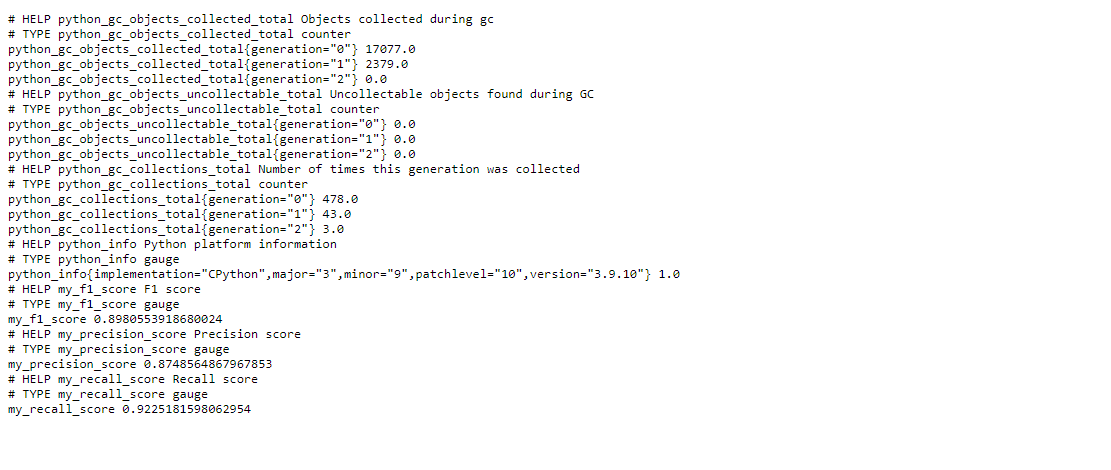

##   Запуск прометея     http://localhost:9090/    Перед запуском Prometheus, произвел    настройки  файла этой программы prometheus.yml, для учета нового задания, которое должен обрабатывать Prometheus. 

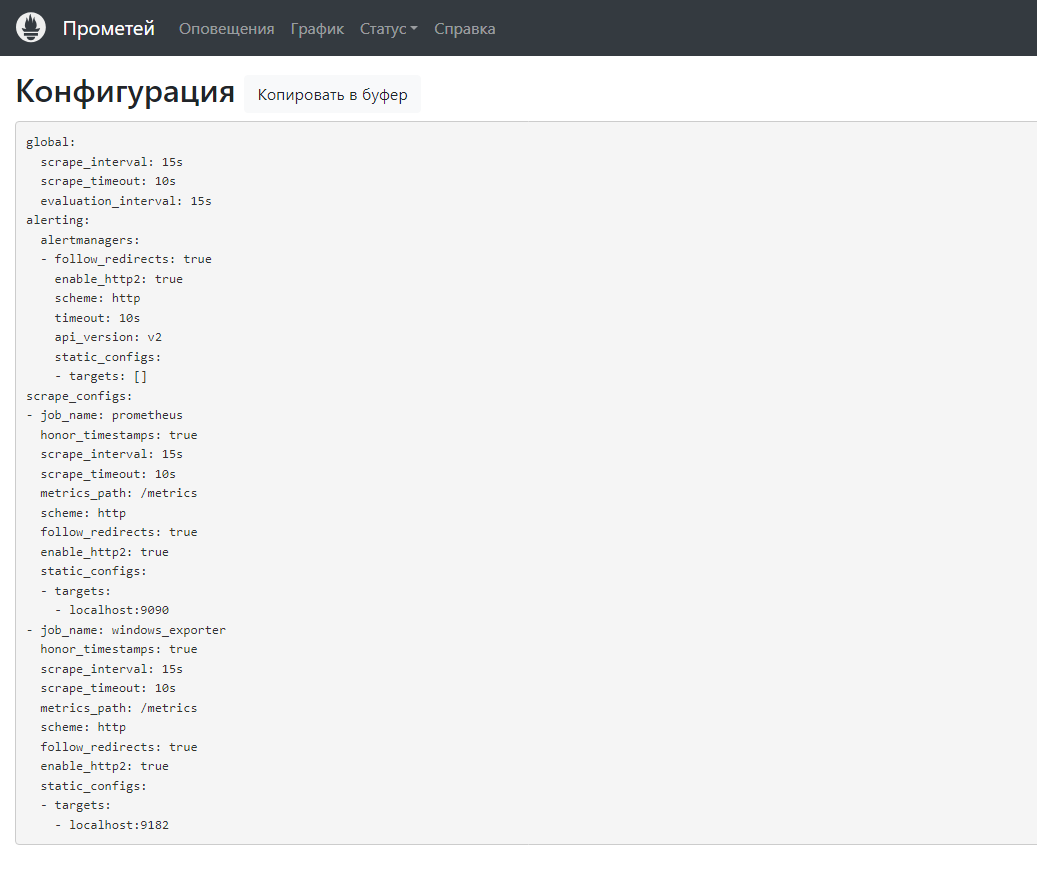

## Заходим  в статус  и потом в  в цели

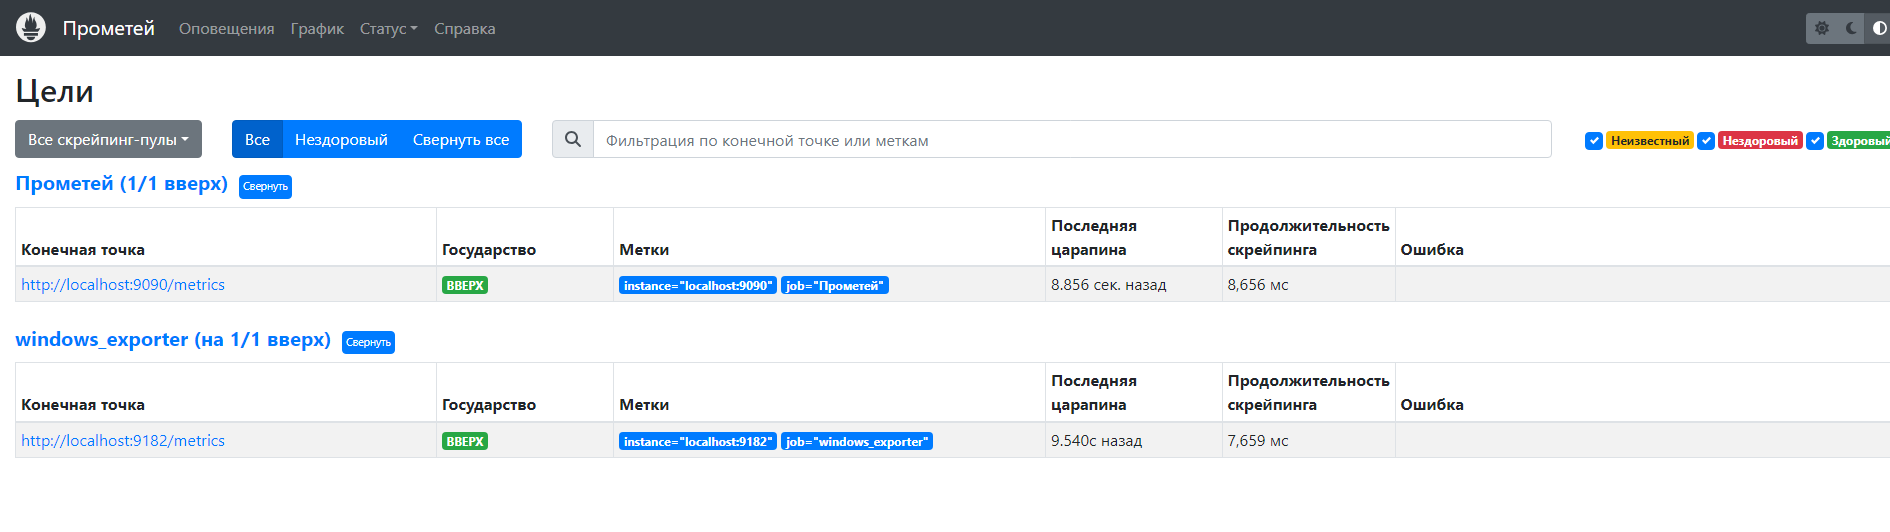

### F1 score: 0.8980553918680024
### Precision: 0.874856486796785
### Recall: 0.9225181598062954

## Заполним панели в Prometeus  метриками     и нажимаем  исполнить 

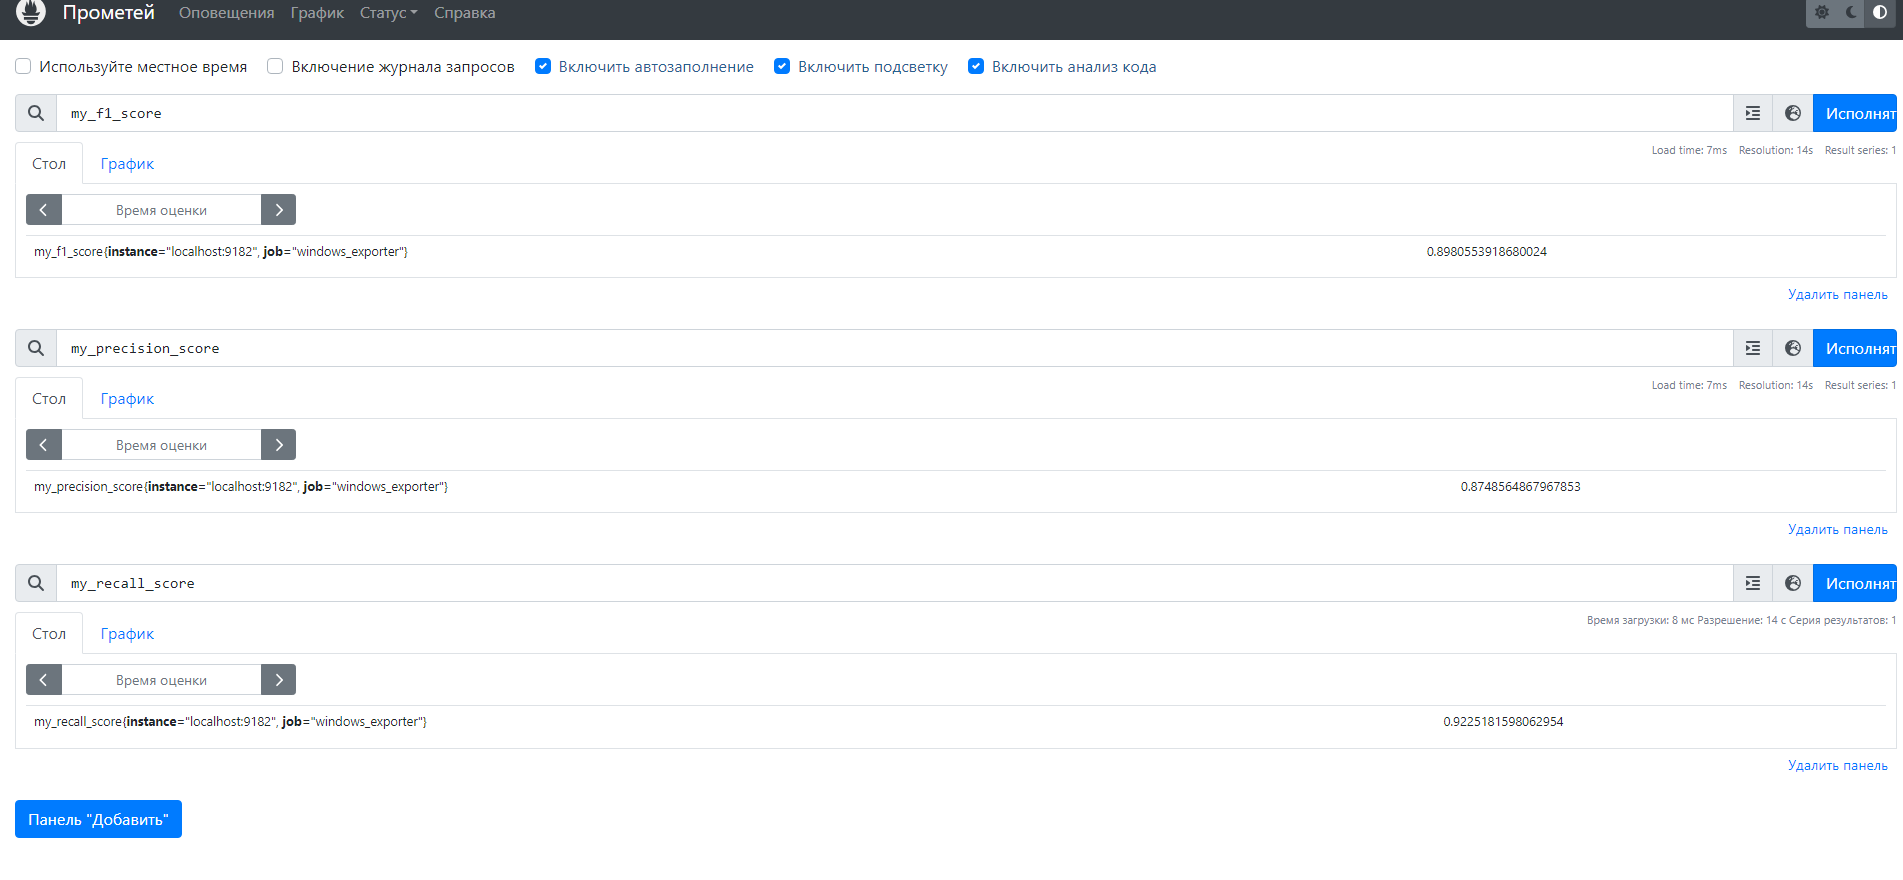

## на каждой панели нужные  нам метрики

# Подключение Prometheus к Grafana.




### подключение через докер  http://host.docker.internal:9090

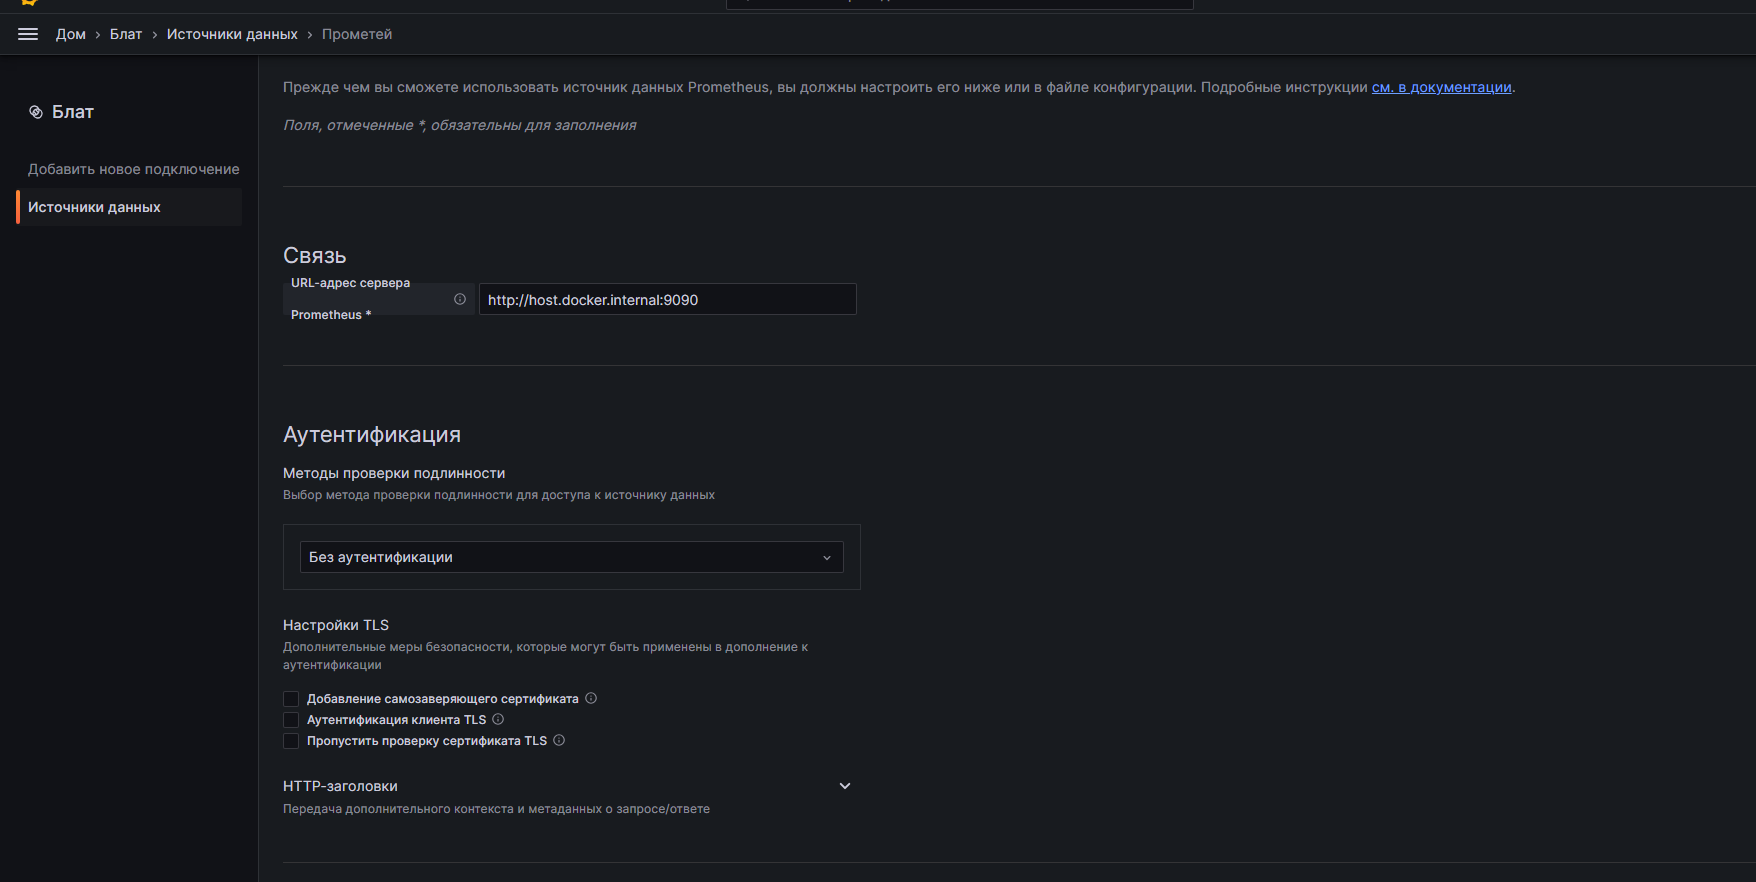

##  Подключен

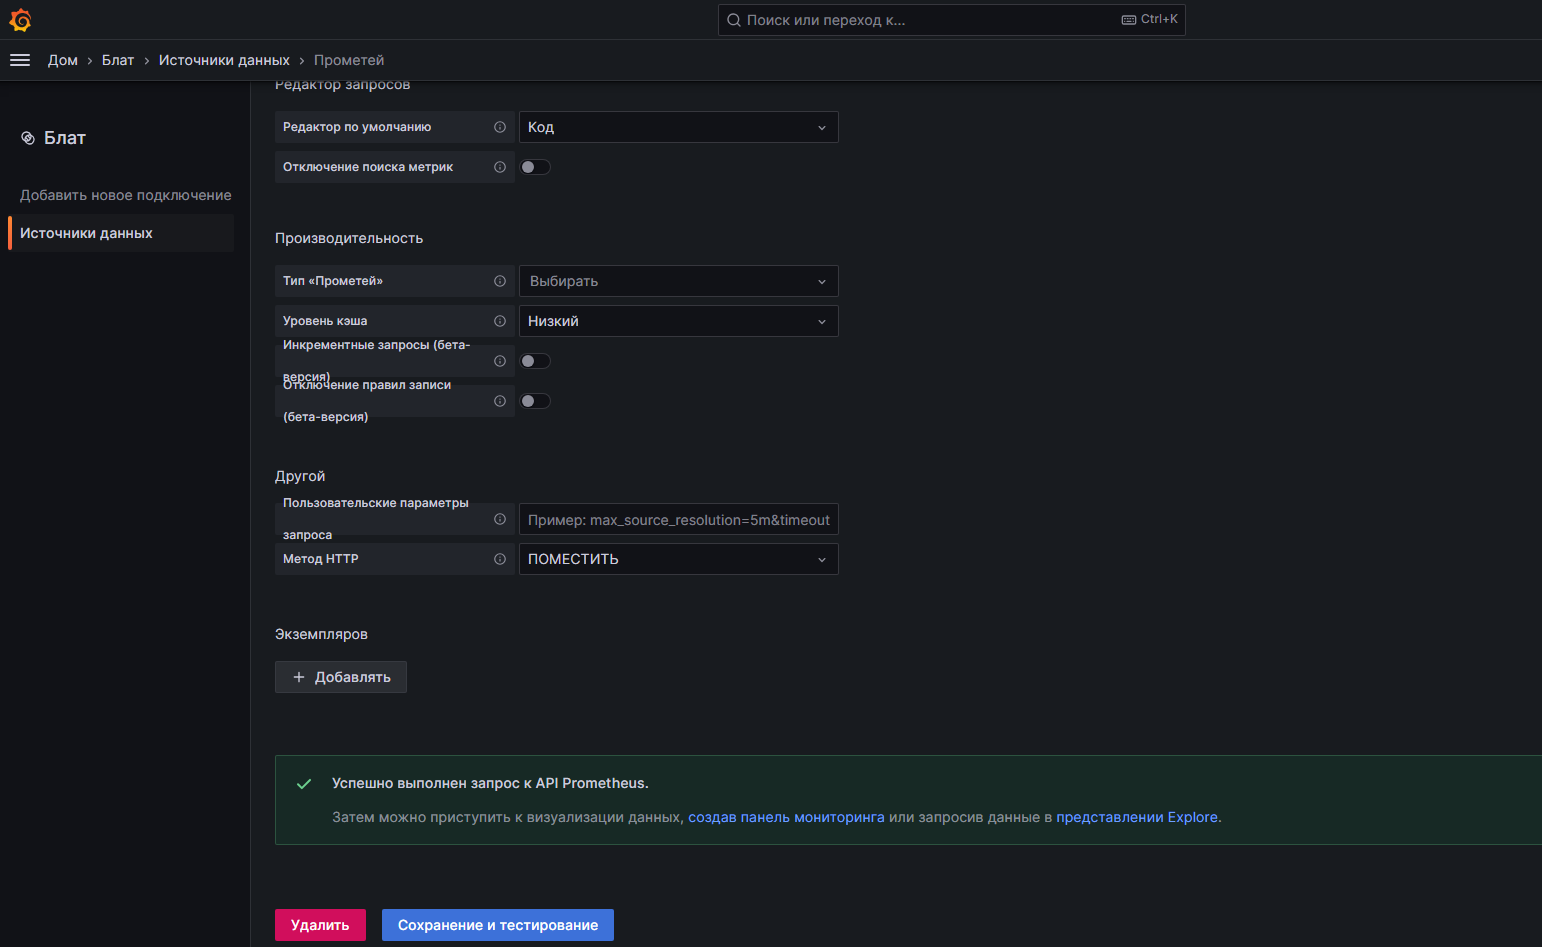

## В запросах находим нужные нам метрики

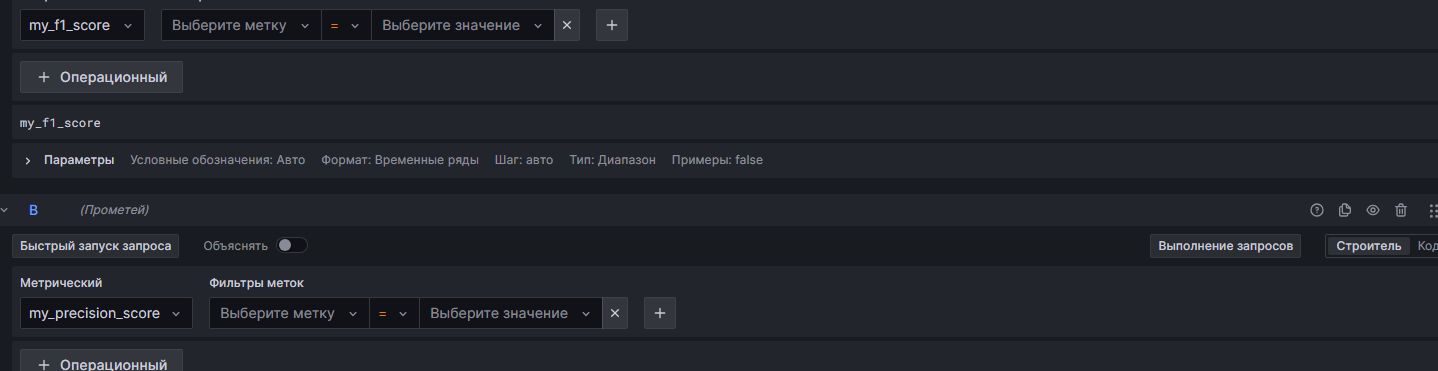

## Сохраним новый дашборд в Grafana с нужными нам для мониторинга метриками. Проект.     Название  -    Проект  Модель для показа рекламных предложений

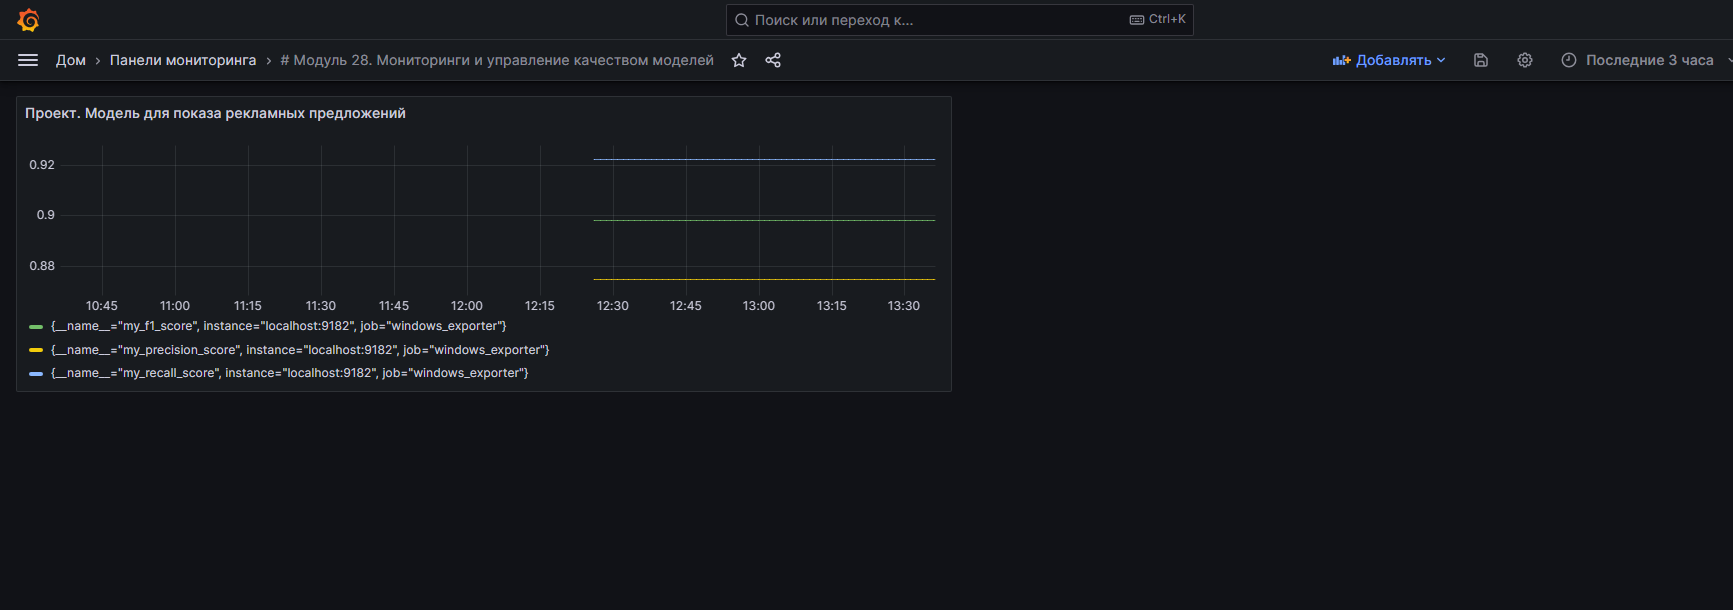

### и пробуем разные визуализации

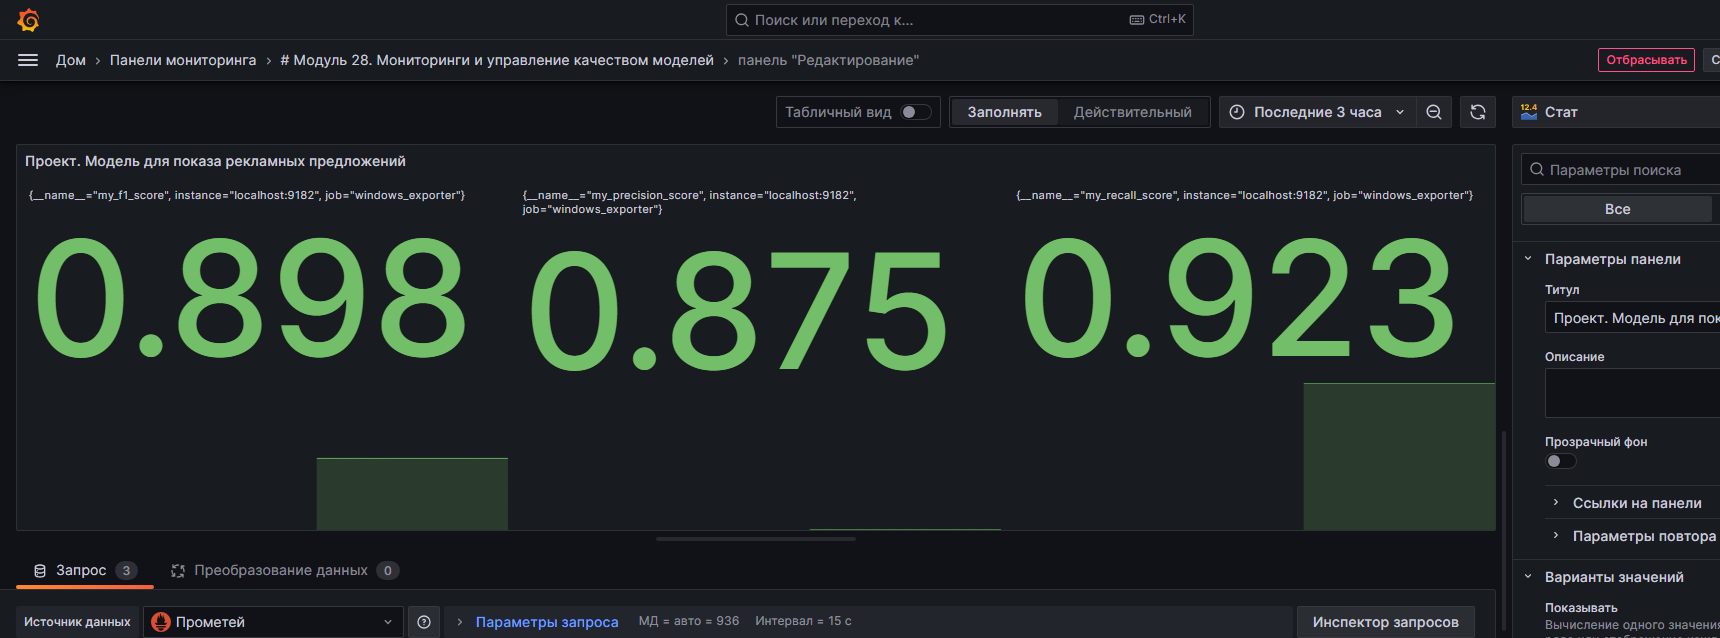

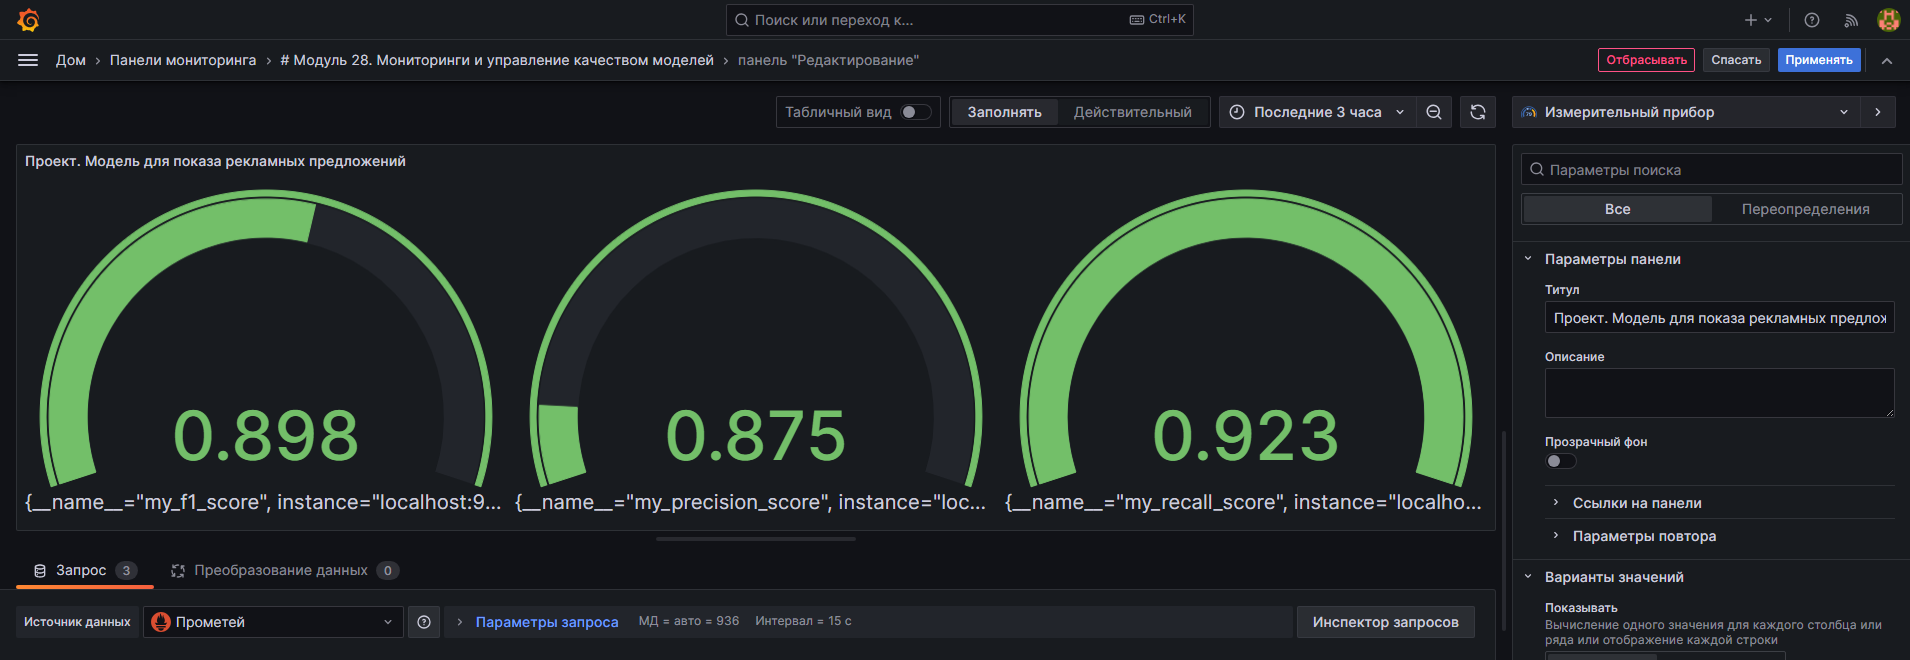